In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

## 1. Структура данных

In [2]:
data = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


### Статистические характеристики

In [3]:
#Анализ номеров счетов (InvoiceNo)
print('Уникальные префиксы в InvoiceNo:')
invoice_prefixes = data['InvoiceNo'].str.extract(r'^(\D+)', expand=False).dropna().unique()
print(f'Найдены префиксы: {invoice_prefixes}')
#Разделение на обычные транзакции и возвраты
data['Is_Cancellation'] = data['InvoiceNo'].str.startswith('C')
data['Is_Discount'] = data['StockCode'].str.contains('D|POST|M', case=False, na=False)
print(f'\nКоличество транзакций с возвратами: {data["Is_Cancellation"].sum()}')
print(f'Количество транзакций со скидками: {data["Is_Discount"].sum()}')

Уникальные префиксы в InvoiceNo:
Найдены префиксы: ['C' 'A']

Количество транзакций с возвратами: 9288
Количество транзакций со скидками: 6957


In [4]:
#Анализ Quantity с разделением на покупки и возвраты
print('Анализ Quantity:')
print('Все транзакции:')
print(f'  Диапазон: [{data["Quantity"].min()} - {data["Quantity"].max()}]')
print(f'  Среднее: {data["Quantity"].mean():.2f}')
print(f'  Медиана: {data["Quantity"].median()}')
print('\nТолько покупки (Quantity > 0):')
purchases = data[data['Quantity'] > 0]
print(f'  Диапазон: [{purchases["Quantity"].min()} - {purchases["Quantity"].max()}]')
print(f'  Среднее: {purchases["Quantity"].mean():.2f}')
print(f'  Медиана: {purchases["Quantity"].median()}')
print('\nТолько возвраты (Quantity < 0):')
returns = data[data['Quantity'] < 0]
print(f'  Диапазон: [{returns["Quantity"].min()} - {returns["Quantity"].max()}]')
print(f'  Среднее: {returns["Quantity"].mean():.2f}')
print(f'  Медиана: {returns["Quantity"].median()}')

Анализ Quantity:
Все транзакции:
  Диапазон: [-80995 - 80995]
  Среднее: 9.55
  Медиана: 3.0

Только покупки (Quantity > 0):
  Диапазон: [1 - 80995]
  Среднее: 10.66
  Медиана: 3.0

Только возвраты (Quantity < 0):
  Диапазон: [-80995 - -1]
  Среднее: -45.61
  Медиана: -2.0


In [5]:
#Анализ UnitPrice
print('\nАнализ UnitPrice:')
print(f'Диапазон: [{data["UnitPrice"].min():.2f} - {data["UnitPrice"].max():.2f}] ₤')
print(f'Среднее: {data["UnitPrice"].mean():.2f} ₤')
print(f'Медиана: {data["UnitPrice"].median():.2f} ₤')
print(f'Количество бесплатных товаров (UnitPrice = 0): {(data["UnitPrice"] == 0).sum()}')


Анализ UnitPrice:
Диапазон: [-11062.06 - 38970.00] ₤
Среднее: 4.61 ₤
Медиана: 2.08 ₤
Количество бесплатных товаров (UnitPrice = 0): 2515


In [6]:
#Уникальные клиенты (исключая пропуски)
valid_customers = data[data['CustomerID'].notna()]
unique_customers = valid_customers['CustomerID'].nunique()
print(f'Количество уникальных клиентов: {unique_customers}')
#Анализ активности клиентов
customer_stats = valid_customers['CustomerID'].value_counts()
print(f'\nСтатистика по транзакциям на клиента:')
print(f'Минимальное количество транзакций: {customer_stats.min()}')
print(f'Максимальное количество транзакций: {customer_stats.max()}')
print(f'Среднее количество транзакций: {customer_stats.mean():.2f}')
print(f'Медианное количество транзакций: {customer_stats.median()}')

Количество уникальных клиентов: 4372

Статистика по транзакциям на клиента:
Минимальное количество транзакций: 1
Максимальное количество транзакций: 7983
Среднее количество транзакций: 93.05
Медианное количество транзакций: 42.0


Количество уникальных стран: 38


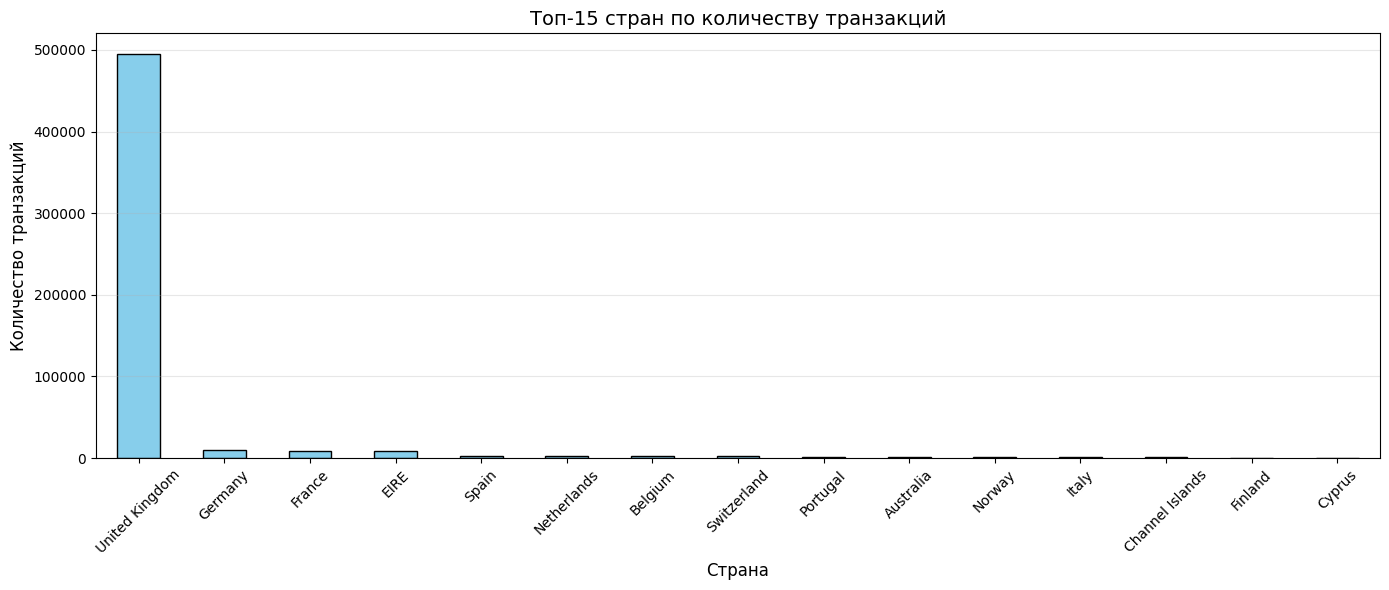

In [7]:
#Уникальные страны
unique_countries = data['Country'].nunique()
print(f'Количество уникальных стран: {unique_countries}')
#Количество транзакций
country_stats = data['Country'].value_counts()
#Визуализация распределения по странам
plt.figure(figsize=(14, 6))
country_stats.head(15).plot(kind='bar', color='skyblue')
plt.title('Топ-15 стран по количеству транзакций', fontsize=14)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
unique_products = data['StockCode'].nunique()
print(f'Количество уникальных товаров: {unique_products}')

Количество уникальных товаров: 4070


### Проверка на наличие пропусков

In [9]:
#Проверка пропусков
print('Пропущенные значения по столбцам:')
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percentage.round(2)
})
print(missing_info[missing_info['Количество пропусков'] > 0])
#Анализ пропусков в CustomerID
missing_customers = data[data['CustomerID'].isna()]
print(f'\nТранзакции без CustomerID: {len(missing_customers)}')
print('Распределение по странам для транзакций без CustomerID:')
print(missing_customers['Country'].value_counts().head(10))

Пропущенные значения по столбцам:
             Количество пропусков  Процент пропусков
Description                  1454               0.27
CustomerID                 135080              24.93

Транзакции без CustomerID: 135080
Распределение по странам для транзакций без CustomerID:
Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: count, dtype: int64


### Проверка на наличие дубликатов

In [10]:
#Проверка дубликатов
total_duplicates = data.duplicated().sum()
print(f'\nОбщее количество полных дубликатов строк: {total_duplicates}')


Общее количество полных дубликатов строк: 5268


### Преобразование форматов данных

In [11]:
#Преобразование даты в datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print(f'Диапазон дат транзакций: от {data["InvoiceDate"].min()} до {data["InvoiceDate"].max()}')
#Дополнительный временной анализ
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Weekday'] = data['InvoiceDate'].dt.weekday
data['Hour'] = data['InvoiceDate'].dt.hour
print(f'\nГоды в данных: {sorted(data["Year"].unique())}')
print(f'Месяцы в данных: {sorted(data["Month"].unique())}')

Диапазон дат транзакций: от 2010-12-01 08:26:00 до 2011-12-09 12:50:00

Годы в данных: [np.int32(2010), np.int32(2011)]
Месяцы в данных: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]


### Зависимость транзакций от года/месяца/дня

In [12]:
#Распределение по месяцам
monthly_transactions = data.groupby(['Year', 'Month']).size()
print('Количество транзакций по месяцам:')
print(monthly_transactions)
#Распределение по дням недели
weekday_transactions = data['Weekday'].value_counts().sort_index()
weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
print('\nКоличество транзакций по дням недели:')
for i, count in weekday_transactions.items():
    print(f'{weekday_names[i]}: {count}')

Количество транзакций по месяцам:
Year  Month
2010  12       42481
2011  1        35147
      2        27707
      3        36748
      4        29916
      5        37030
      6        36874
      7        39518
      8        35284
      9        50226
      10       60742
      11       84711
      12       25525
dtype: int64

Количество транзакций по дням недели:
Пн: 95111
Вт: 101808
Ср: 94565
Чт: 103857
Пт: 82193
Вс: 64375


## 2. Преобразование, очистка и анализ данных

### Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалим их из данных

In [13]:
#Размер данных до очистки
print(f'Размер данных до удаления пропусков: {data.shape}')
#Количество пропусков до очистки
missing_before = data.isnull().sum()
print('\nПропуски до очистки:')
print(missing_before[missing_before > 0])
#Удаляем строки с пропусками в CustomerID
data_cleaned = data.dropna(subset=['CustomerID'])
#Проверяем, что пропуски в Description также удалились
missing_after = data_cleaned.isnull().sum()
print(f'\nРазмер данных после удаления пропусков: {data_cleaned.shape}')
print('\nПропуски после очистки:')
print(missing_after[missing_after > 0])
#Проверяем, что действительно все пропуски удалены
assert data_cleaned['CustomerID'].isnull().sum() == 0, "Есть пропуски в CustomerID!"
assert data_cleaned['Description'].isnull().sum() == 0, "Есть пропуски в Description!"

Размер данных до удаления пропусков: (541909, 15)

Пропуски до очистки:
Description      1454
CustomerID     135080
dtype: int64

Размер данных после удаления пропусков: (406829, 15)

Пропуски после очистки:
Series([], dtype: int64)


### Дубликаты

In [14]:
#Размер данных до удаления дубликатов
print(f'Размер данных до удаления дубликатов: {data.shape}')
#Проверяем количество полных дубликатов
total_duplicates = data.duplicated().sum()
print(f'Количество полных дубликатов строк: {total_duplicates}')
if total_duplicates > 0:
    print('\nПример дублированных строк:')
    duplicated_rows = data[data.duplicated(keep=False)]  #Все дубликаты (и оригиналы и копии)
    display(duplicated_rows.head(10))
    #Анализ дубликатов по ключевым столбцам
    print('\nАнализ дубликатов по ключевым комбинациям:')
    #Дубликаты по комбинации InvoiceNo + StockCode + Quantity
    invoice_stock_dup = data.duplicated(subset=['InvoiceNo', 'StockCode', 'Quantity'], keep=False).sum()
    print(f'Дубликаты по (InvoiceNo + StockCode + Quantity): {invoice_stock_dup} строк')
    #Дубликаты по комбинации InvoiceNo + StockCode
    invoice_stock_dup2 = data.duplicated(subset=['InvoiceNo', 'StockCode'], keep=False).sum()
    print(f'Дубликаты по (InvoiceNo + StockCode): {invoice_stock_dup2} строк')
    #Дубликаты по комбинации InvoiceNo + CustomerID + InvoiceDate
    invoice_customer_dup = data.duplicated(subset=['InvoiceNo', 'CustomerID', 'InvoiceDate'], keep=False).sum()
    print(f'Дубликаты по (InvoiceNo + CustomerID + InvoiceDate): {invoice_customer_dup} строк')
#Удаляем полные дубликаты, сохраняя первую встретившуюся строку
data_cleaned = data.drop_duplicates()
print(f'\nРазмер данных после удаления дубликатов: {data_cleaned.shape}')
print(f'Удалено дубликатов: {len(data) - len(data_cleaned)}')
#Проверяем, что дубликатов больше нет
remaining_duplicates = data_cleaned.duplicated().sum()
print(f'Оставшиеся дубликаты после очистки: {remaining_duplicates}')

Размер данных до удаления дубликатов: (541909, 15)
Количество полных дубликатов строк: 5268

Пример дублированных строк:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Is_Cancellation,Is_Discount,Year,Month,Day,Weekday,Hour
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom,False,False,2010,12,1,2,11
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom,False,False,2010,12,1,2,11
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom,False,False,2010,12,1,2,11
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom,False,False,2010,12,1,2,11
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom,False,False,2010,12,1,2,11
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom,False,False,2010,12,1,2,11
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom,False,False,2010,12,1,2,11
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom,False,False,2010,12,1,2,11
548,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920,United Kingdom,False,False,2010,12,1,2,11
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920,United Kingdom,False,False,2010,12,1,2,11



Анализ дубликатов по ключевым комбинациям:
Дубликаты по (InvoiceNo + StockCode + Quantity): 10426 строк
Дубликаты по (InvoiceNo + StockCode): 20378 строк
Дубликаты по (InvoiceNo + CustomerID + InvoiceDate): 536059 строк

Размер данных после удаления дубликатов: (536641, 15)
Удалено дубликатов: 5268
Оставшиеся дубликаты после очистки: 0


In [15]:
#Размер данных до удаления логических дубликатов
print(f'Размер данных до удаления логических дубликатов: {data.shape}')
#Ключевые столбцы для идентификации уникальных транзакций
key_columns = ['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'CustomerID', 'InvoiceDate']
#Проверяем количество логических дубликатов
logical_duplicates = data.duplicated(subset=key_columns, keep=False).sum()
print(f'Количество логических дубликатов: {logical_duplicates} строк')
if logical_duplicates > 0:
    print('\nПример логических дубликатов:')
    dup_examples = data[data.duplicated(subset=key_columns, keep=False)]
    display(dup_examples.sort_values(by=key_columns).head(10))
    #Анализируем природу дубликатов
    print('\nАнализ природы дубликатов:')
    duplicate_groups = data[data.duplicated(subset=key_columns, keep=False)]
    #Проверяем, есть ли различия в других столбцах
    different_columns = []
    for col in data.columns:
        if col not in key_columns:
            grouped = duplicate_groups.groupby(key_columns)[col].nunique()
            if (grouped > 1).any():
                different_columns.append(col)
    if different_columns:
        print(f'Столбцы, где есть различия у дубликатов: {different_columns}')
        #Покажем примеры различий
        for col in different_columns[:3]:  #Покажем первые 3 столбца с различиями
            examples = duplicate_groups.groupby(key_columns)[col].filter(lambda x: x.nunique() > 1)
            if not examples.empty:
                print(f'\nПример различий в столбце {col}:')
                sample_group = duplicate_groups.groupby(key_columns)[col].first().reset_index()
                display(sample_group.head(5))
    else:
        print('Все дубликаты полностью идентичны по всем столбцам')
#Удаляем логические дубликаты, оставляя первую запись
data_cleaned = data.drop_duplicates(subset=key_columns, keep='first')
print(f'\nРазмер данных после удаления логических дубликатов: {data_cleaned.shape}')
print(f'Удалено логических дубликатов: {len(data) - len(data_cleaned)}')
#Проверяем, что логических дубликатов больше нет
remaining_logical_duplicates = data_cleaned.duplicated(subset=key_columns, keep=False).sum()
print(f'Оставшиеся логические дубликаты: {remaining_logical_duplicates}')

Размер данных до удаления логических дубликатов: (541909, 15)
Количество логических дубликатов: 10151 строк

Пример логических дубликатов:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Is_Cancellation,Is_Discount,Year,Month,Day,Weekday,Hour
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom,False,False,2010,12,1,2,11
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom,False,False,2010,12,1,2,11
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom,False,False,2010,12,1,2,11
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom,False,False,2010,12,1,2,11
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom,False,False,2010,12,1,2,11
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom,False,False,2010,12,1,2,11
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom,False,False,2010,12,1,2,11
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom,False,False,2010,12,1,2,11
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920,United Kingdom,False,False,2010,12,1,2,11
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920,United Kingdom,False,False,2010,12,1,2,11



Анализ природы дубликатов:
Столбцы, где есть различия у дубликатов: ['Description']

Пример различий в столбце Description:


,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,InvoiceDate,Description
0,536409,21866,1,1.25,17908,2010-12-01 11:45:00,UNION JACK FLAG LUGGAGE TAG
1,536409,22111,1,4.95,17908,2010-12-01 11:45:00,SCOTTIE DOG HOT WATER BOTTLE
2,536409,22866,1,2.10,17908,2010-12-01 11:45:00,HAND WARMER SCOTTY DOG DESIGN
3,536409,22900,1,2.95,17908,2010-12-01 11:45:00,SET 2 TEA TOWELS I LOVE LONDON
4,536412,21448,1,1.65,17920,2010-12-01 11:49:00,12 DAISY PEGS IN WOOD BOX



Размер данных после удаления логических дубликатов: (536639, 15)
Удалено логических дубликатов: 5270
Оставшиеся логические дубликаты: 0


### Транзакции с отрицательным количеством товара

In [16]:
data = data_cleaned.copy()

In [17]:
#Анализ возвратов
negative_quantity = data[data['Quantity'] < 0]
positive_quantity = data[data['Quantity'] > 0]
zero_quantity = data[data['Quantity'] == 0]
print(f'Транзакции с положительным Quantity: {len(positive_quantity)}')
print(f'Транзакции с отрицательным Quantity: {len(negative_quantity)}')
print(f'Транзакции с нулевым Quantity: {len(zero_quantity)}')
#Анализ возвратов по типам (с префиксом 'C' и без)
negative_with_c = negative_quantity[negative_quantity['InvoiceNo'].str.startswith('C')]
negative_without_c = negative_quantity[~negative_quantity['InvoiceNo'].str.startswith('C')]
print(f'\nВозвраты с префиксом "C": {len(negative_with_c)}')
print(f'Возвраты без префикса "C": {len(negative_without_c)}')
#Анализ скидочных товаров в возвратах
discount_returns = negative_quantity[negative_quantity['Is_Discount']]
print(f'Возвраты скидочных товаров: {len(discount_returns)}')
#Подсчет количества товаров в каждой корзине
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns={'InvoiceDate': 'Number of products'})
print('Количество товаров в корзинах (первые 10 записей):')
display(nb_products_per_basket.head(10))
#Статистика по размеру корзин
print('\nСтатистика по количеству товаров в корзинах:')
print(f'Минимальное количество товаров: {nb_products_per_basket["Number of products"].min()}')
print(f'Максимальное количество товаров: {nb_products_per_basket["Number of products"].max()}')
print(f'Среднее количество товаров: {nb_products_per_basket["Number of products"].mean():.2f}')
print(f'Медианное количество товаров: {nb_products_per_basket["Number of products"].median()}')

Транзакции с положительным Quantity: 526052
Транзакции с отрицательным Quantity: 10587
Транзакции с нулевым Quantity: 0

Возвраты с префиксом "C": 9251
Возвраты без префикса "C": 1336
Возвраты скидочных товаров: 556
Количество товаров в корзинах (первые 10 записей):


,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17



Статистика по количеству товаров в корзинах:
Минимальное количество товаров: 1
Максимальное количество товаров: 542
Среднее количество товаров: 18.10
Медианное количество товаров: 12.0


In [18]:
#Анализ корзин с возвратами
baskets_with_returns = data[data['Quantity'] < 0]['InvoiceNo'].unique()
print(f'\nКоличество уникальных корзин с возвратами: {len(baskets_with_returns)}')
#Для дальнейшего анализа создадим флаг возврата для каждой транзакции
data['Is_Return'] = data['Quantity'] < 0
data['Is_Full_Return'] = data['InvoiceNo'].str.startswith('C')
#Анализ полных и частичных возвратов
full_returns = data[data['Is_Full_Return']]
partial_returns = data[(data['Quantity'] < 0) & (~data['Is_Full_Return'])]
print(f'Полные возвраты (префикс "C"): {len(full_returns)} транзакций')
print(f'Частичные возвраты: {len(partial_returns)} транзакций')
#Группировка по клиентам для анализа возвратов
customer_returns = data[data['Is_Return']].groupby('CustomerID').agg({
    'Quantity': 'sum',
    'InvoiceNo': 'nunique',
    'StockCode': 'nunique'
}).rename(columns={
    'Quantity': 'Total_Return_Quantity',
    'InvoiceNo': 'Number_of_Return_Transactions',
    'StockCode': 'Number_of_Return_Products'
})
customer_returns['Total_Return_Quantity'] = customer_returns['Total_Return_Quantity'].abs()
print('\nСтатистика по возвратам клиентов:')
print(f'Клиентов с возвратами: {len(customer_returns)}')
print(f'Среднее количество возвратных транзакций на клиента: {customer_returns["Number_of_Return_Transactions"].mean():.2f}')
print(f'Максимальное количество возвратных транзакций у одного клиента: {customer_returns["Number_of_Return_Transactions"].max()}')
#Пример клиентов с наибольшим количеством возвратов
print('\nТоп-5 клиентов по количеству возвратов:')
top_returning_customers = customer_returns.nlargest(5, 'Number_of_Return_Transactions')
display(top_returning_customers)


Количество уникальных корзин с возвратами: 5172
Полные возвраты (префикс "C"): 9251 транзакций
Частичные возвраты: 1336 транзакций

Статистика по возвратам клиентов:
Клиентов с возвратами: 1589
Среднее количество возвратных транзакций на клиента: 2.30
Максимальное количество возвратных транзакций у одного клиента: 47

Топ-5 клиентов по количеству возвратов:


,Total_Return_Quantity,Number_of_Return_Transactions,Number_of_Return_Products
CustomerID,,,
14911,3335,47,187
17841,206,45,107
14606,246,35,73
14527,40,31,5
15311,474,27,55


In [19]:
#Объединяем с основными данными
data = data.merge(
    nb_products_per_basket, 
    on=['CustomerID', 'InvoiceNo'], 
    how='left'
)

Создадим в наших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым

In [20]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    #Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        #Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        #Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        #Транзакция-возврат имеет ровно одного контрагента
        #Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        #Транзакция-возврат имеет несколько контрагентов
        #Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        #в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

In [21]:
#Статистика по QuantityCanceled
total_transactions = len(data)
with_canceled = data['QuantityCanceled'].notna().sum()
positive_canceled = (data['QuantityCanceled'] > 0).sum()
zero_canceled = (data['QuantityCanceled'] == 0).sum()
nan_canceled = data['QuantityCanceled'].isna().sum()
print(f'Всего транзакций: {total_transactions:,}')
print(f'Транзакций с QuantityCanceled (не NaN): {with_canceled:,}')
print(f'Транзакций с QuantityCanceled > 0: {positive_canceled:,}')
print(f'Транзакций с QuantityCanceled = 0: {zero_canceled:,}')
print(f'Транзакций с QuantityCanceled = NaN: {nan_canceled:,}')

Всего транзакций: 536,639
Транзакций с QuantityCanceled (не NaN): 533,621
Транзакций с QuantityCanceled > 0: 7,216
Транзакций с QuantityCanceled = 0: 526,405
Транзакций с QuantityCanceled = NaN: 3,018


In [22]:
#Транзакции с отрицательным Quantity
negative_transactions = data[data['Quantity'] < 0]
positive_transactions = data[data['Quantity'] >= 0]
print(f'Транзакций с отрицательным Quantity: {len(negative_transactions):,}')
print(f'Транзакций с неотрицательным Quantity: {len(positive_transactions):,}')
#Удаляем транзакции с отрицательным Quantity
data = data[data['Quantity'] >= 0].copy()

Транзакций с отрицательным Quantity: 10,587
Транзакций с неотрицательным Quantity: 526,052


### Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений можно найти коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).\
Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.
Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны

In [23]:
#Поиск специальных кодов товаров, начинающихся с латинских букв
special_pattern = '^[a-zA-Z]+'
special_transactions = data[data['StockCode'].str.contains(special_pattern, na=False, regex=True)]
print(f'Найдено специальных транзакций: {len(special_transactions):,}')
print(f'Процент специальных транзакций: {len(special_transactions)/len(data)*100:.2f}%')
#Анализ найденных специальных транзакций
if len(special_transactions) > 0:
    print('\nУникальные специальные коды товаров:')
    special_codes = special_transactions['StockCode'].unique()
    print(special_codes)
    print('\nОписания специальных транзакций:')
    special_descriptions = special_transactions.groupby(['StockCode', 'Description']).size().reset_index(name='Count')
    display(special_descriptions.sort_values('Count', ascending=False))
    #Анализ по типам специальных транзакций
    print('\nРаспределение специальных транзакций по типам:')
    special_counts = special_transactions['StockCode'].value_counts()
    print(special_counts)
    #Анализ по странам
    print('\nРаспределение специальных транзакций по странам:')
    print(special_transactions['Country'].value_counts().head(10))
    #Анализ по клиентам
    print('\nТоп клиентов со специальными транзакциями:')
    special_customers = special_transactions['CustomerID'].value_counts().head(10)
    print(special_customers)

Найдено специальных транзакций: 2,394
Процент специальных транзакций: 0.46%

Уникальные специальные коды товаров:
['POST' 'C2' 'DOT' 'M' 'BANK CHARGES' 'AMAZONFEE' 'DCGS0076' 'DCGS0003'
 'gift_0001_40' 'DCGS0070' 'm' 'gift_0001_50' 'gift_0001_30'
 'gift_0001_20' 'DCGS0069' 'DCGSSBOY' 'DCGSSGIRL' 'gift_0001_10' 'S'
 'PADS' 'DCGS0004' 'B']

Описания специальных транзакций:


,StockCode,Description,Count
14,POST,POSTAGE,1126
11,DOT,DOTCOM POSTAGE,708
12,M,Manual,322
3,C2,CARRIAGE,141
10,DCGSSGIRL,GIRLS PARTY BAG,13
2,BANK CHARGES,Bank Charges,12
9,DCGSSBOY,BOYS PARTY BAG,11
17,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,9
16,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,8
19,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,7



Распределение специальных транзакций по типам:
StockCode
POST            1130
DOT              709
M                322
C2               142
DCGSSGIRL         13
BANK CHARGES      12
DCGSSBOY          11
gift_0001_20      10
gift_0001_10       9
gift_0001_30       8
DCGS0003           4
PADS               4
gift_0001_50       4
B                  3
gift_0001_40       3
AMAZONFEE          2
DCGS0076           2
S                  2
m                  1
DCGS0070           1
DCGS0069           1
DCGS0004           1
Name: count, dtype: int64

Распределение специальных транзакций по странам:
Country
United Kingdom    1164
Germany            383
France             308
EIRE               111
Belgium             96
Spain               62
Finland             38
Netherlands         37
Portugal            37
Switzerland         31
Name: count, dtype: int64

Топ клиентов со специальными транзакциями:
CustomerID
14911    86
12569    31
12682    29
12681    22
12471    21
12621    18
12540    17
1

In [24]:
#Удаление специальных транзакций
data_cleaned = data[~data['StockCode'].str.contains(special_pattern, na=False, regex=True)].copy()
print(f'Удалено специальных транзакций: {len(special_transactions):,}')
print(f'Осталось транзакций: {len(data_cleaned):,}')
print(f'Процент удаленных данных: {len(special_transactions)/len(data)*100:.2f}%')

Удалено специальных транзакций: 2,394
Осталось транзакций: 523,658
Процент удаленных данных: 0.46%


### Транзакции с товарами без стоимости

In [25]:
#Анализ транзакций с нулевой ценой
zero_price_transactions = data[data['UnitPrice'] == 0]
positive_price_transactions = data[data['UnitPrice'] > 0]
print(f'Всего транзакций: {len(data):,}')
print(f'Транзакций с нулевой ценой: {len(zero_price_transactions):,}')
print(f'Транзакций с положительной ценой: {len(positive_price_transactions):,}')
print(f'Процент транзакций с нулевой ценой: {len(zero_price_transactions)/len(data)*100:.2f}%')
#Детальный анализ транзакций с нулевой ценой
if len(zero_price_transactions) > 0:
    print('\nДетальный анализ транзакций с нулевой ценой:')
    #Анализ по товарам
    print('Топ товаров с нулевой ценой:')
    zero_price_products = zero_price_transactions['StockCode'].value_counts().head(10)
    print(zero_price_products)
    #Анализ по описаниям
    print('\nОписания товаров с нулевой ценой:')
    zero_price_descriptions = zero_price_transactions.groupby(['StockCode', 'Description']).size().reset_index(name='Count')
    display(zero_price_descriptions.sort_values('Count', ascending=False))
    #Анализ по клиентам
    print('\nТоп клиентов с транзакциями нулевой цены:')
    zero_price_customers = zero_price_transactions['CustomerID'].value_counts().head(10)
    print(zero_price_customers)
    #Анализ по странам
    print('\nРаспределение по странам:')
    print(zero_price_transactions['Country'].value_counts().head(10))
    #Анализ Quantity для нулевых цен
    print('\nСтатистика Quantity для транзакций с нулевой ценой:')
    print(zero_price_transactions['Quantity'].describe())
    #Проверка, есть ли среди них возвраты
    zero_price_returns = zero_price_transactions[zero_price_transactions['Quantity'] < 0]
    print(f'\nТранзакций возвратов с нулевой ценой: {len(zero_price_returns):,}')
    
if len(zero_price_transactions) / len(data) < 0.01:  #Менее 1%
    print('Количество транзакций с нулевой ценой менее 1%, удаляем их.')
    data_cleaned = data[data['UnitPrice'] > 0].copy()
    print(f'Удалено транзакций с нулевой ценой: {len(zero_price_transactions):,}')
    print(f'Осталось транзакций: {len(data_cleaned):,}')
else:
    print('Количество транзакций с нулевой ценой значительное (>1%), требуется дополнительный анализ.')
    data_cleaned = data.copy()

Всего транзакций: 526,052
Транзакций с нулевой ценой: 1,174
Транзакций с положительной ценой: 524,876
Процент транзакций с нулевой ценой: 0.22%

Детальный анализ транзакций с нулевой ценой:
Топ товаров с нулевой ценой:
StockCode
23084    13
35965    11
22676     9
22683     8
20713     8
22686     7
22501     7
22679     7
22678     7
22627     7
Name: count, dtype: int64

Описания товаров с нулевой ценой:


,StockCode,Description,Count
202,22676,FRENCH BLUE METAL DOOR SIGN 1,9
209,22683,FRENCH BLUE METAL DOOR SIGN 8,8
212,22686,FRENCH BLUE METAL DOOR SIGN No,7
33,21116,OWL DOORSTOP,7
204,22678,FRENCH BLUE METAL DOOR SIGN 3,7
...,...,...,...
11,20665,dotcom,1
7,17136A,check,1
6,17109D,Adjustment,1
5,17091A,found,1



Топ клиентов с транзакциями нулевой цены:
CustomerID
13081    4
14646    4
14911    2
13985    2
12415    2
16560    1
15107    1
13239    1
13113    1
12457    1
Name: count, dtype: int64

Распределение по странам:
Country
United Kingdom    1156
EIRE                 4
Netherlands          4
Australia            3
Germany              2
Switzerland          1
Spain                1
RSA                  1
France               1
Norway               1
Name: count, dtype: int64

Статистика Quantity для транзакций с нулевой ценой:
count     1174.000000
mean        61.837308
std        454.442215
min          1.000000
25%          1.000000
50%          3.000000
75%         20.000000
max      12540.000000
Name: Quantity, dtype: float64

Транзакций возвратов с нулевой ценой: 0
Количество транзакций с нулевой ценой менее 1%, удаляем их.
Удалено транзакций с нулевой ценой: 1,174
Осталось транзакций: 524,876


In [26]:
data = data_cleaned.copy()

### Общая стоимость товаров транзакции

In [27]:
#Проверяем наличие необходимых столбцов
required_columns = ['UnitPrice', 'Quantity', 'QuantityCanceled']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    print(f'Ошибка: Отсутствуют необходимые столбцы: {missing_columns}')
else:
    print('Все необходимые столбцы присутствуют')
#Заменяем NaN в QuantityCanceled на 0 (для транзакций без возвратов)
data['QuantityCanceled'] = data['QuantityCanceled'].fillna(0)
#Проверяем, что нет отрицательных значений в QuantityCanceled
if (data['QuantityCanceled'] < 0).any():
    print('Внимание: Обнаружены отрицательные значения в QuantityCanceled!')
    data['QuantityCanceled'] = data['QuantityCanceled'].abs()
#Рассчитываем эффективное количество товаров (с учетом возвратов)
data['EffectiveQuantity'] = data['Quantity'] - data['QuantityCanceled']
#Проверяем, что эффективное количество не отрицательное
negative_effective = data[data['EffectiveQuantity'] < 0]
if len(negative_effective) > 0:
    print(f'Внимание: Обнаружено {len(negative_effective)} транзакций с отрицательным EffectiveQuantity!')
    print('Исправляем...')
    data['EffectiveQuantity'] = data['EffectiveQuantity'].clip(lower=0)
#Рассчитываем общую цену заказа
data['TotalPrice'] = data['UnitPrice'] * data['EffectiveQuantity']
print(f'Признак TotalPrice добавлен')
print(f'Размер данных: {data.shape}')

Все необходимые столбцы присутствуют
Внимание: Обнаружено 38 транзакций с отрицательным EffectiveQuantity!
Исправляем...
Признак TotalPrice добавлен
Размер данных: (524876, 21)


In [28]:
#Основная статистика
print('Статистика TotalPrice:')
print(data['TotalPrice'].describe())
#Анализ распределения
print(f'\nМинимальная общая цена: {data["TotalPrice"].min():.4f} ₤')
print(f'Максимальная общая цена: {data["TotalPrice"].max():.4f} ₤')
print(f'Средняя общая цена: {data["TotalPrice"].mean():.2f} ₤')
print(f'Медианная общая цена: {data["TotalPrice"].median():.2f} ₤')

Статистика TotalPrice:
count    524876.000000
mean         19.339039
std          71.672790
min           0.000000
25%           3.750000
50%           9.900000
75%          17.700000
max       13541.330000
Name: TotalPrice, dtype: float64

Минимальная общая цена: 0.0000 ₤
Максимальная общая цена: 13541.3300 ₤
Средняя общая цена: 19.34 ₤
Медианная общая цена: 9.90 ₤


### Разведывательный анализ

Топ-10 стран по выручке:


,Unique_Customers,Unique_Orders,Total_Revenue,Total_Quantity
Country,,,,
United Kingdom,3920,18019,8552233.864,4414177.0
Netherlands,9,94,284937.540,200033.0
EIRE,3,288,273151.970,142967.0
Germany,94,457,223448.480,117548.0
France,87,392,201705.750,110493.0
Australia,9,57,136950.250,83348.0
Spain,30,90,57616.900,26810.0
Switzerland,21,54,56367.400,30312.0
Belgium,25,98,40891.040,23153.0


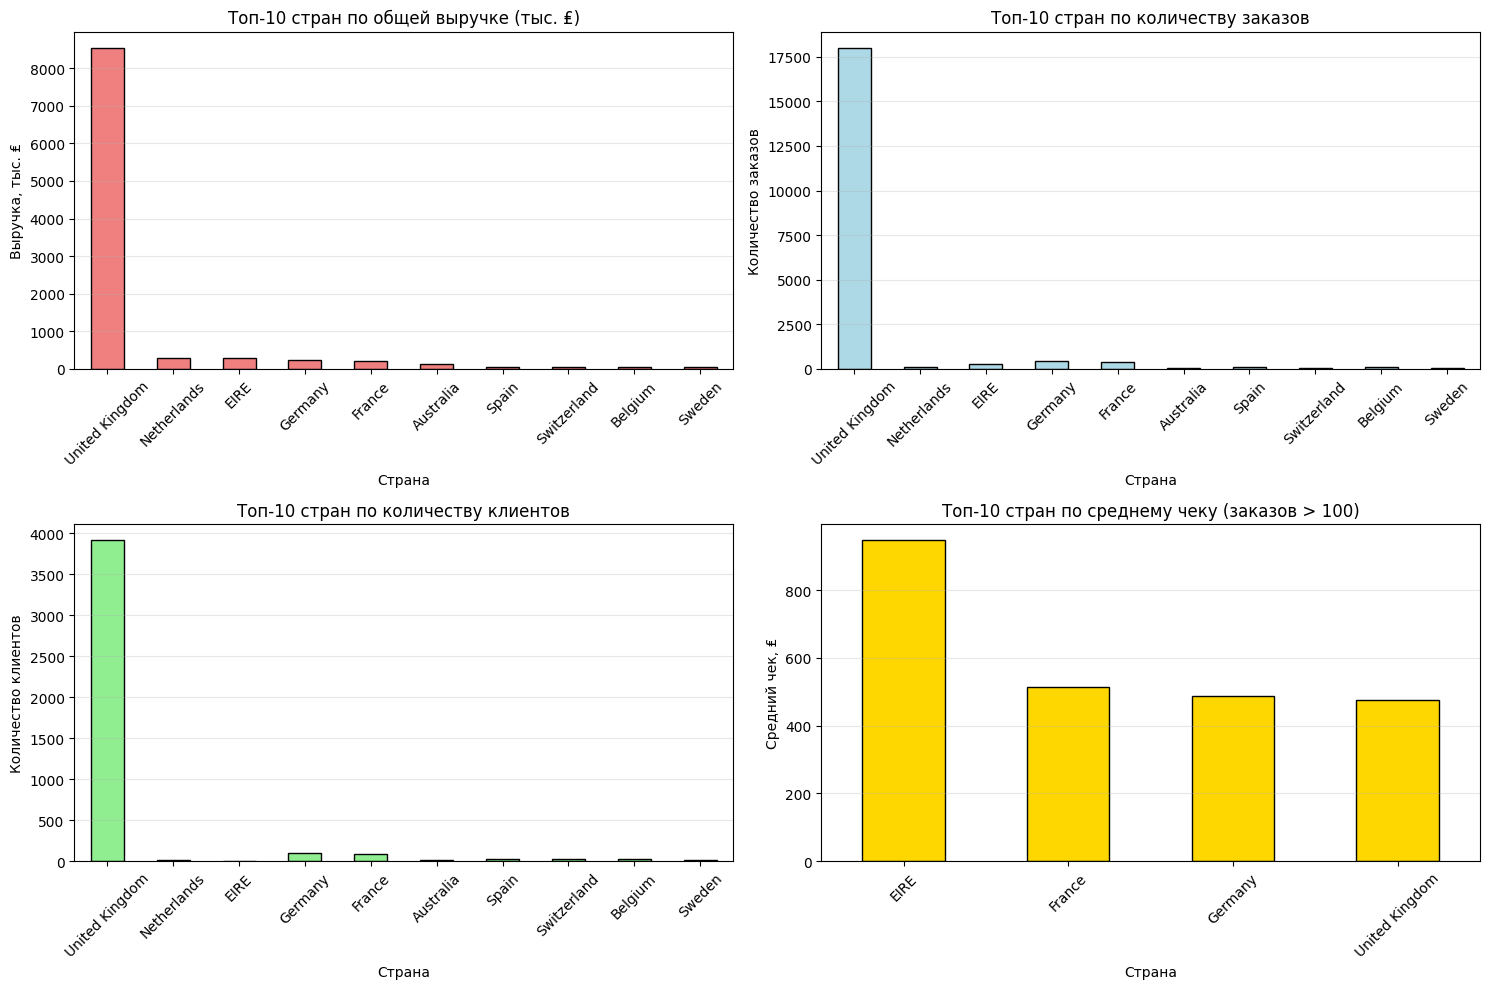

In [29]:
#Клиенты из каких стран покупают больше и чаще?
country_stats = data.groupby('Country').agg({
    'CustomerID': 'nunique',
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum',
    'EffectiveQuantity': 'sum'
}).rename(columns={
    'CustomerID': 'Unique_Customers',
    'InvoiceNo': 'Unique_Orders',
    'TotalPrice': 'Total_Revenue',
    'EffectiveQuantity': 'Total_Quantity'
}).sort_values('Total_Revenue', ascending=False)
print('Топ-10 стран по выручке:')
display(country_stats.head(10))

#Визуализация
plt.figure(figsize=(15, 10))
#Топ стран по выручке
plt.subplot(2, 2, 1)
top_countries_revenue = country_stats.head(10)['Total_Revenue'] / 1000  #в тысячах
top_countries_revenue.plot(kind='bar', color='lightcoral')
plt.title('Топ-10 стран по общей выручке (тыс. ₤)')
plt.xlabel('Страна')
plt.ylabel('Выручка, тыс. ₤')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
#Топ стран по количеству заказов
plt.subplot(2, 2, 2)
top_countries_orders = country_stats.head(10)['Unique_Orders']
top_countries_orders.plot(kind='bar', color='lightblue')
plt.title('Топ-10 стран по количеству заказов')
plt.xlabel('Страна')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
#Топ стран по количеству клиентов
plt.subplot(2, 2, 3)
top_countries_customers = country_stats.head(10)['Unique_Customers']
top_countries_customers.plot(kind='bar', color='lightgreen')
plt.title('Топ-10 стран по количеству клиентов')
plt.xlabel('Страна')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
#Средний чек по странам
country_stats['Avg_Order_Value'] = country_stats['Total_Revenue'] / country_stats['Unique_Orders']
plt.subplot(2, 2, 4)
top_countries_avg = country_stats[country_stats['Unique_Orders'] > 100].nlargest(10, 'Avg_Order_Value')['Avg_Order_Value']
top_countries_avg.plot(kind='bar', color='gold')
plt.title('Топ-10 стран по среднему чеку (заказов > 100)')
plt.xlabel('Страна')
plt.ylabel('Средний чек, ₤')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

По количествуюк клиентов, количеству заказов и общей выручке лидирует United Kingddom.\
Средний чек выше у EIRE - видимо, Ирландия - редкие покупатели, но на большой чек

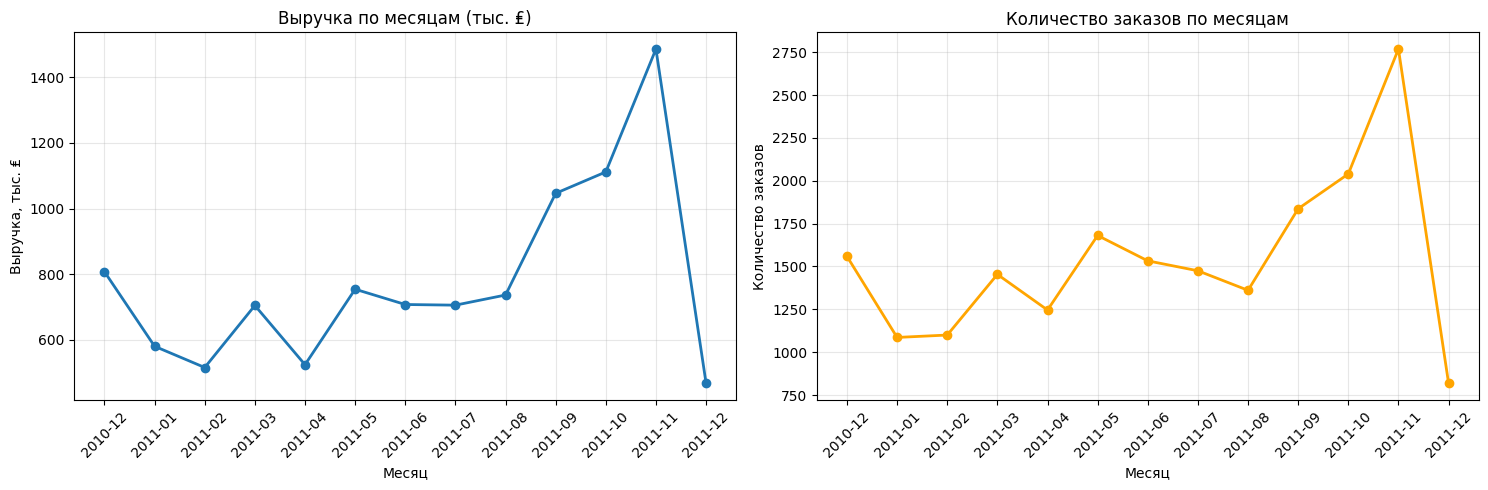

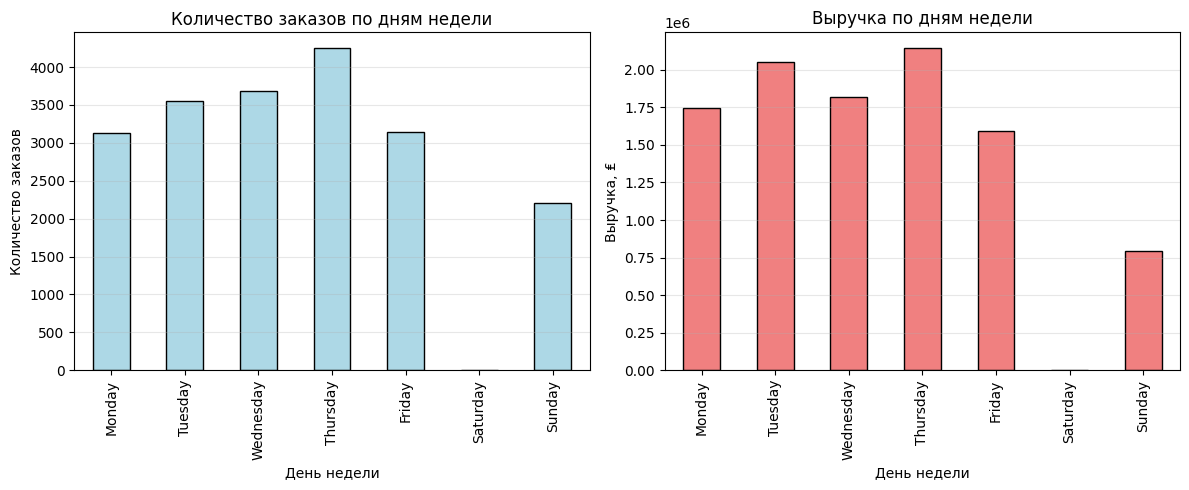

In [30]:
#Сезонный анализ
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
data['MonthName'] = data['InvoiceDate'].dt.month_name()
#Сезонность продаж по месяцам
monthly_stats = data.groupby(['Year', 'Month', 'MonthName']).agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum',
    'CustomerID': 'nunique'
}).rename(columns={
    'InvoiceNo': 'Orders_Count',
    'TotalPrice': 'Monthly_Revenue',
    'CustomerID': 'Active_Customers'
}).reset_index()
monthly_stats['YearMonth'] = monthly_stats['Year'].astype(str) + '-' + monthly_stats['Month'].astype(str).str.zfill(2)
plt.figure(figsize=(15, 5))
#Выручка по месяцам
plt.subplot(1, 2, 1)
plt.plot(monthly_stats['YearMonth'], monthly_stats['Monthly_Revenue']/1000, marker='o', linewidth=2)
plt.title('Выручка по месяцам (тыс. ₤)')
plt.xlabel('Месяц')
plt.ylabel('Выручка, тыс. ₤')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
#Количество заказов по месяцам
plt.subplot(1, 2, 2)
plt.plot(monthly_stats['YearMonth'], monthly_stats['Orders_Count'], marker='o', color='orange', linewidth=2)
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
#Сезонность по дням недели
weekday_stats = data.groupby('DayOfWeek').agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceNo': 'Orders_Count',
    'TotalPrice': 'Daily_Revenue'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
weekday_stats['Orders_Count'].plot(kind='bar', color='lightblue')
plt.title('Количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.grid(axis='y', alpha=0.3)
plt.subplot(1, 2, 2)
weekday_stats['Daily_Revenue'].plot(kind='bar', color='lightcoral')
plt.title('Выручка по дням недели')
plt.xlabel('День недели')
plt.ylabel('Выручка, ₤')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Пик заказов на ноябрь - месяц перед праздниками.\
Пик выручки на четверг

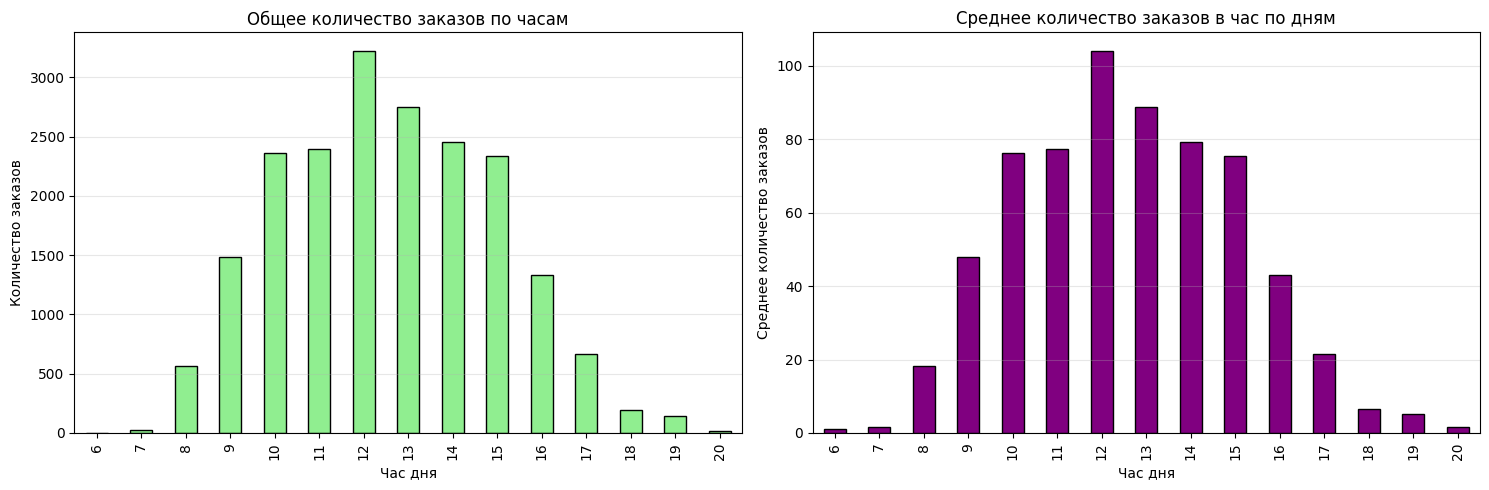

In [31]:
#Анализ по времени суток
#Распределение заказов по часам
hourly_stats = data.groupby('Hour').agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceNo': 'Orders_Count',
    'TotalPrice': 'Hourly_Revenue'
})
#Среднее количество заказов в час по дням
daily_hourly_stats = data.groupby(['Day', 'Hour'])['InvoiceNo'].nunique().reset_index()
avg_hourly_orders = daily_hourly_stats.groupby('Hour')['InvoiceNo'].mean()
plt.figure(figsize=(15, 5))
#Общее количество заказов по часам
plt.subplot(1, 2, 1)
hourly_stats['Orders_Count'].plot(kind='bar', color='lightgreen')
plt.title('Общее количество заказов по часам')
plt.xlabel('Час дня')
plt.ylabel('Количество заказов')
plt.grid(axis='y', alpha=0.3)
#Среднее количество заказов в час
plt.subplot(1, 2, 2)
avg_hourly_orders.plot(kind='bar', color='purple')
plt.title('Среднее количество заказов в час по дням')
plt.xlabel('Час дня')
plt.ylabel('Среднее количество заказов')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Пик заказов приходится на обеденное время

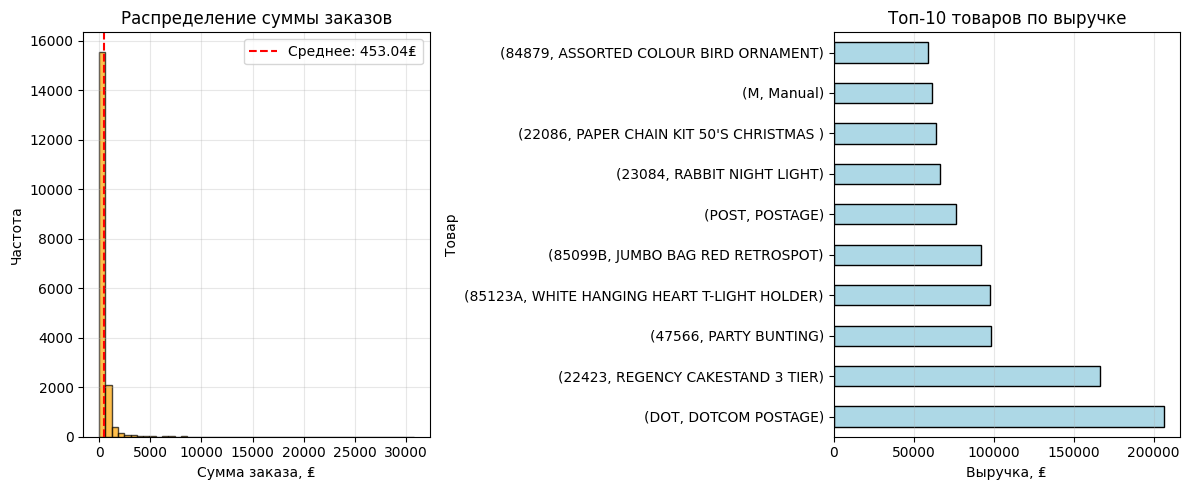

Статистика по покупательскому поведению:
       Total_Orders    Total_Spent    Total_Items
count   4338.000000    4338.000000    4338.000000
mean       4.272015    1935.383950    1131.109036
std        7.697998    8383.457719    4699.246733
min        1.000000       0.000000       0.000000
25%        1.000000     300.597500     156.250000
50%        2.000000     655.640000     369.500000
75%        5.000000    1624.117500     970.750000
max      209.000000  279765.020000  196624.000000


In [32]:
#Распределение суммы заказов
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
order_values = data.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].sum()
plt.hist(order_values, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Распределение суммы заказов')
plt.xlabel('Сумма заказа, ₤')
plt.ylabel('Частота')
plt.axvline(order_values.mean(), color='red', linestyle='--', label=f'Среднее: {order_values.mean():.2f}₤')
plt.legend()
plt.grid(alpha=0.3)
#Топ товаров по выручке
top_products = data.groupby(['StockCode', 'Description']).agg({
    'TotalPrice': 'sum',
    'EffectiveQuantity': 'sum'
}).nlargest(10, 'TotalPrice')
plt.subplot(1, 2, 2)
top_products['TotalPrice'].plot(kind='barh', color='lightblue')
plt.title('Топ-10 товаров по выручке')
plt.xlabel('Выручка, ₤')
plt.ylabel('Товар')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
#Анализ покупательского поведения
customer_behavior = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum',
    'EffectiveQuantity': 'sum'
}).rename(columns={
    'InvoiceNo': 'Total_Orders',
    'TotalPrice': 'Total_Spent',
    'EffectiveQuantity': 'Total_Items'
})
print('Статистика по покупательскому поведению:')
print(customer_behavior.describe())

## Построение RFM-таблицы и поиск RFM-выбросов

In [33]:
#Точка отсчета (на один день старше максимальной даты в данных)
t0 = pd.Timestamp('2011-12-10 00:00:00')
print(f'Точка отсчета (t0): {t0}')
#Максимальная дата в данных
max_date_in_data = data['InvoiceDate'].max()
print(f'Максимальная дата в данных: {max_date_in_data}')
print(f'Разница между t0 и max_date: {t0 - max_date_in_data}')
#Группируем данные по клиентам и рассчитываем RFM-показатели
rfm_table = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (t0 - x.max()).days,  #Recency (в днях)
    'InvoiceNo': 'nunique',                        #Frequency (уникальные заказы)
    'TotalPrice': 'sum'                            #Monetary Value (общая сумма)
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency', 
    'TotalPrice': 'MonetaryValue'
}).reset_index()
print(f'Размер RFM-таблицы: {rfm_table.shape}')
print('\nПервые 10 строк RFM-таблицы:')
display(rfm_table.head(10))

Точка отсчета (t0): 2011-12-10 00:00:00
Максимальная дата в данных: 2011-12-09 12:50:00
Разница между t0 и max_date: 0 days 11:10:00
Размер RFM-таблицы: (4338, 4)

Первые 10 строк RFM-таблицы:


,CustomerID,Recency,Frequency,MonetaryValue
0,12346,325,1,0.00
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,18,1,1757.55
4,12350,310,1,334.40
5,12352,36,8,2385.71
6,12353,204,1,89.00
7,12354,232,1,1079.40
8,12355,214,1,459.40
9,12356,22,3,2811.43
